# Predicting the Gross Revenue of a Movie

## Import Libraries & Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import catboost as cat
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [2]:
train = pd.read_csv('Dataset/train.csv',sep=';')
test = pd.read_csv('Dataset/test.csv',sep=';')

In [3]:
train.head()

,movie_ID,num_critic_for_reviews,picture_type,duration,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,movie_facebook_likes,num_voted_users,language,num_user_for_reviews,budget,origin_country,title_year,movie_rating,aspect_ratio,countries_launched_in,content_rating,gross
0,1,590.0,Color,67.0,36.0,NaN,19608,842,0,306697.0,English,714.0,4.202473e+08,USA,2010,4.1,2.39,87.0,PG-13,126203320.0
1,2,126.0,Color,127.0,79.0,12000.0,506,50,11000,44198.0,English,251.0,4.465423e+06,USA,2005,7.9,2.39,4.0,R,5128124.0
2,3,50.0,Color,126.0,0.0,25976.0,23081,1607,3591,153876.0,English,1.0,1.392281e+08,USA,1993,7.0,1.89,63.0,R,44886089.0
3,4,393.0,Color,130.0,770.0,22371.0,709,0,0,150012.0,English,303.0,1.907334e+07,UK,2015,8.0,1.89,1.0,R,35024475.0
4,5,190.0,Color,109.0,453.0,18000.0,11000,2000,0,94892.0,NaN,189.0,5.271869e+07,USA,2008,6.8,1.89,16.0,R,26415649.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   movie_ID                 7050 non-null   int64  
 1   num_critic_for_reviews   6928 non-null   float64
 2   picture_type             6624 non-null   object 
 3   duration                 6855 non-null   float64
 4   director_facebook_likes  6894 non-null   float64
 5   actor_1_facebook_likes   6852 non-null   float64
 6   actor_2_facebook_likes   7050 non-null   int64  
 7   actor_3_facebook_likes   7050 non-null   int64  
 8   movie_facebook_likes     7050 non-null   int64  
 9   num_voted_users          6861 non-null   float64
 10  language                 6924 non-null   object 
 11  num_user_for_reviews     6973 non-null   float64
 12  budget                   6945 non-null   float64
 13  origin_country           6904 non-null   object 
 14  title_year              

## EDA & Feature Engineering

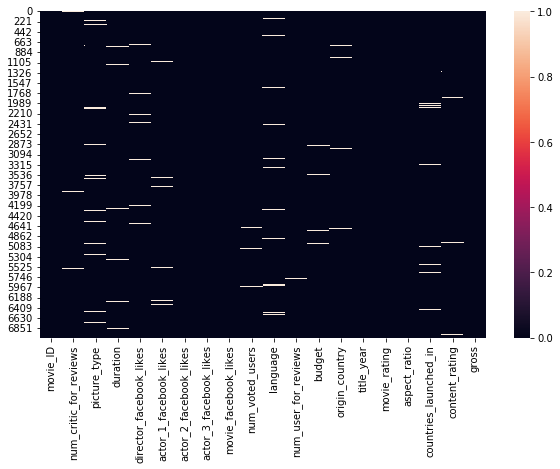

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(train.isnull())

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   movie_ID                 7050 non-null   int64  
 1   num_critic_for_reviews   6928 non-null   float64
 2   picture_type             6624 non-null   object 
 3   duration                 6855 non-null   float64
 4   director_facebook_likes  6894 non-null   float64
 5   actor_1_facebook_likes   6852 non-null   float64
 6   actor_2_facebook_likes   7050 non-null   int64  
 7   actor_3_facebook_likes   7050 non-null   int64  
 8   movie_facebook_likes     7050 non-null   int64  
 9   num_voted_users          6861 non-null   float64
 10  language                 6924 non-null   object 
 11  num_user_for_reviews     6973 non-null   float64
 12  budget                   6945 non-null   float64
 13  origin_country           6904 non-null   object 
 14  title_year              

In [7]:
train.isnull().sum().sort_values()

movie_ID                     0
aspect_ratio                 0
movie_rating                 0
title_year                   0
movie_facebook_likes         0
actor_3_facebook_likes       0
gross                        0
actor_2_facebook_likes       0
num_user_for_reviews        77
budget                     105
num_critic_for_reviews     122
language                   126
origin_country             146
content_rating             155
director_facebook_likes    156
num_voted_users            189
duration                   195
actor_1_facebook_likes     198
countries_launched_in      245
picture_type               426
dtype: int64

In [8]:
train['total_likes'] = (train['director_facebook_likes']+train['actor_1_facebook_likes']+train['actor_2_facebook_likes']
                        +train['actor_3_facebook_likes']+train['movie_facebook_likes'])
train['avg_total_likes'] = (train['director_facebook_likes']+train['actor_1_facebook_likes']+train['actor_2_facebook_likes']
                        +train['actor_3_facebook_likes']+train['movie_facebook_likes'])/len(train)


test['total_likes'] = (test['director_facebook_likes']+test['actor_1_facebook_likes']+test['actor_2_facebook_likes']
                        +test['actor_3_facebook_likes']+test['movie_facebook_likes'])
test['avg_total_likes'] = (test['director_facebook_likes']+test['actor_1_facebook_likes']+test['actor_2_facebook_likes']
                        +test['actor_3_facebook_likes']+test['movie_facebook_likes'])/len(test)

Text(0.5, 1.0, 'Test set')

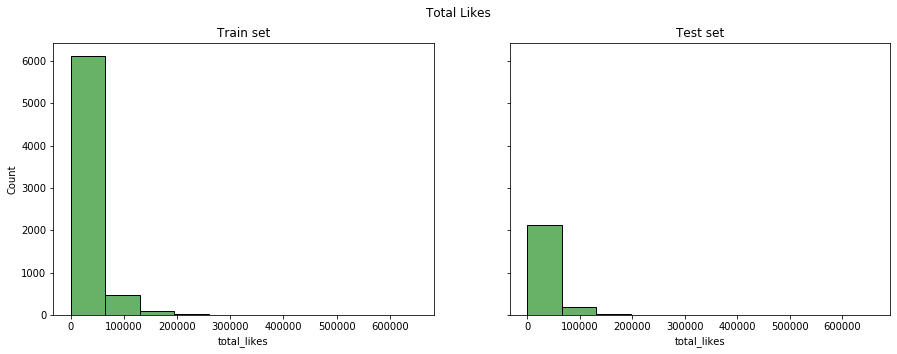

In [9]:
fig, axes = plt.subplots(1,2, figsize=(15, 5), sharey=True)
fig.suptitle('Total Likes')

sns.histplot(ax=axes[0],data=train['total_likes'],bins=10,color='g',alpha=0.6)
axes[0].set_title('Train set')

sns.histplot(ax=axes[1],data=test['total_likes'],bins=10,color='g',alpha=0.6)
axes[1].set_title('Test set')

Text(0.5, 1.0, 'Test set')

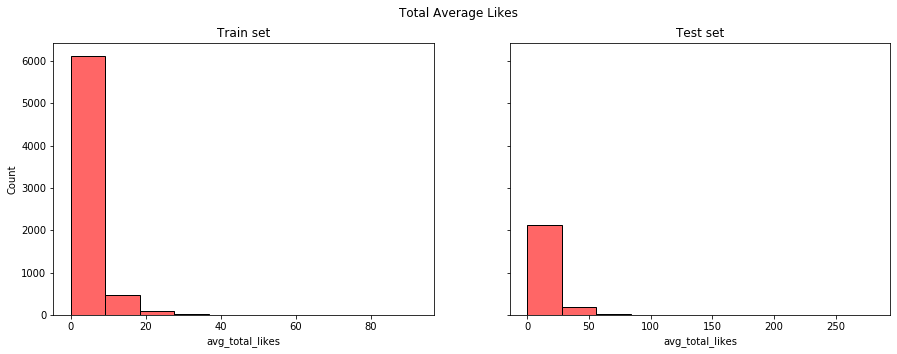

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15, 5), sharey=True)
fig.suptitle('Total Average Likes')

sns.histplot(ax=axes[0],data=train['avg_total_likes'],bins=10,color='r',alpha=0.6)
axes[0].set_title('Train set')

sns.histplot(ax=axes[1],data=test['avg_total_likes'],bins=10,color='r',alpha=0.6)
axes[1].set_title('Test set')

In [11]:
sc = StandardScaler()

labels=train['gross'].values
train.drop(['gross'],axis=1,inplace=True)

labels=labels[:,np.newaxis]
labels = sc.fit_transform(labels)

#non_null_num_cols = ['actor_2_facebook_likes','actor_3_facebook_likes','movie_facebook_likes','title_year','movie_rating','aspect_ratio']

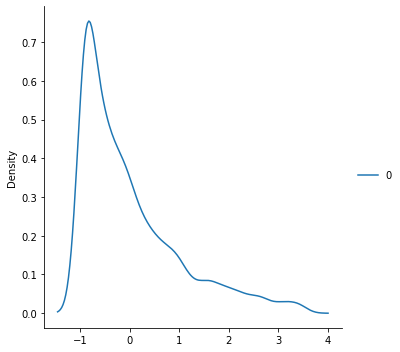

In [12]:
#distribution of labels
sns.displot(labels,kind='kde')

In [13]:
str_cols = ['picture_type','origin_country','language','content_rating'] #string columns

train[str_cols]=train[str_cols].fillna('Nan')
test[str_cols]=test[str_cols].fillna('Nan')
str_cols.remove('language')
train[str_cols] = train[str_cols].astype('category')

In [14]:
#categorical encoding of langugae column in train set
train_lang_dummies = pd.get_dummies(train['language'])
train = pd.concat([train,train_lang_dummies],axis=1)
train.drop(['language'],axis=1,inplace=True)

#total reviews in train set
train['total_reviews']=train['num_critic_for_reviews']+train['num_user_for_reviews']

In [15]:
#categorical encoding of langugae column in test set
test_lang_dummies = pd.get_dummies(test['language'])
test = pd.concat([test,test_lang_dummies],axis=1)
test[str_cols]=test[str_cols].astype('category')
test.drop(['language'],axis=1,inplace=True)

#total reviews in test set
test['total_reviews']=test['num_critic_for_reviews']+test['num_user_for_reviews']

Text(0.5, 1.0, 'Test set')

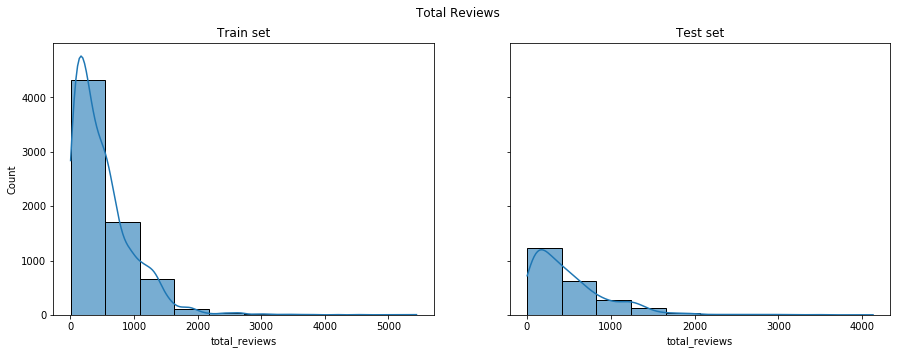

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15, 5), sharey=True)
fig.suptitle('Total Reviews')

sns.histplot(ax=axes[0],data=train['total_reviews'],bins=10,alpha=0.6,kde=True)
axes[0].set_title('Train set')

sns.histplot(ax=axes[1],data=test['total_reviews'],bins=10,alpha=0.6,kde=True)
axes[1].set_title('Test set')

## Model Building and Evaluation

### CatBoost Regressor

In [17]:
X_train = cat.Pool(train, labels,cat_features=str_cols) 

cb = cat.CatBoostRegressor(loss_function='RMSE',verbose=0)

In [18]:
#hyperparameter tuning, randomized search
grid = {'iterations': [1000, 1200, 1500],
        'learning_rate': [5e-2,6e-2],
        'depth': [5,6,7],
        'l2_leaf_reg': [5,6,7,8]}
cb.randomized_search(grid, X_train,n_iter=20,cv=4)


bestTest = 0.3995671519
bestIteration = 999

0:	loss: 0.3995672	best: 0.3995672 (0)	total: 25.6s	remaining: 8m 6s

bestTest = 0.3993190324
bestIteration = 999

1:	loss: 0.3993190	best: 0.3993190 (1)	total: 43s	remaining: 6m 26s

bestTest = 0.3968853022
bestIteration = 1197

2:	loss: 0.3968853	best: 0.3968853 (2)	total: 1m 9s	remaining: 6m 33s

bestTest = 0.4006029413
bestIteration = 1197

3:	loss: 0.4006029	best: 0.3968853 (2)	total: 1m 36s	remaining: 6m 27s

bestTest = 0.3958747546
bestIteration = 1199

4:	loss: 0.3958748	best: 0.3958748 (4)	total: 2m 3s	remaining: 6m 11s

bestTest = 0.399896497
bestIteration = 1198

5:	loss: 0.3998965	best: 0.3958748 (4)	total: 2m 32s	remaining: 5m 54s

bestTest = 0.3992173148
bestIteration = 1199

6:	loss: 0.3992173	best: 0.3958748 (4)	total: 3m	remaining: 5m 34s

bestTest = 0.3967789776
bestIteration = 1491

7:	loss: 0.3967790	best: 0.3958748 (4)	total: 3m 34s	remaining: 5m 21s

bestTest = 0.3987423725
bestIteration = 1199

8:	loss: 0.3987424	best

{'params': {'depth': 7,
  'l2_leaf_reg': 7,
  'iterations': 1500,
  'learning_rate': 0.06},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [19]:
r2_score(labels,cb.predict(train))

0.9768541748217482

In [20]:
X_test = cat.Pool(test,cat_features=str_cols)

In [22]:
#catboost predictions
cb_pred = cb.predict(X_test)
cb_pred = sc.inverse_transform(cb_pred)
cb_pred = abs(cb_pred)

### XGBoost Regressor

In [23]:
train = pd.get_dummies(data = train,columns=str_cols,drop_first=True)
test = pd.get_dummies(data=test, columns=str_cols,drop_first=True)


xgb = XGBRegressor(random_state=128)
xgb.fit(train,labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=128,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
r2_score(labels,xgb.predict(train))

0.984969899486088

In [26]:
#xgb predictions
xgb_pred = xgb.predict(test)
xgb_pred = sc.inverse_transform(xgb_pred)
xgb_pred = abs(xgb_pred)

### LightGBM Regressor

In [27]:
lgb = LGBMRegressor(random_state=128)
lgb.fit(train,labels)

C:\Users\Suraj Vardhan Naidu\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


LGBMRegressor(random_state=128)

In [30]:
r2_score(lgb.predict(train),labels)

0.937967528101794

In [31]:
#lgb predictions
lgb_pred = lgb.predict(test)
lgb_pred = sc.inverse_transform(lgb_pred)
lgb_pred = abs(lgb_pred)

In [ ]:
## feature importances of 3 models

In [32]:
cb.feature_importances_,cb.feature_names_

(array([4.21531625e+00, 6.24955478e+00, 1.73878341e-01, 3.06315109e+00,
        2.64676191e+00, 2.04574187e+00, 2.41148028e+00, 2.75104239e+00,
        2.67650026e+00, 3.83713146e+00, 6.68505981e+00, 2.06647244e+01,
        1.41403870e-01, 2.40103473e+00, 3.78102922e+00, 3.17674482e-01,
        4.70662462e+00, 1.09819358e+01, 1.31407918e+00, 1.20079855e+00,
        3.81447709e-03, 5.24655277e-04, 4.94820859e-02, 3.32320004e-02,
        1.10917926e-02, 3.66446439e-02, 1.76002870e+01]),
 ['movie_ID',
  'num_critic_for_reviews',
  'picture_type',
  'duration',
  'director_facebook_likes',
  'actor_1_facebook_likes',
  'actor_2_facebook_likes',
  'actor_3_facebook_likes',
  'movie_facebook_likes',
  'num_voted_users',
  'num_user_for_reviews',
  'budget',
  'origin_country',
  'title_year',
  'movie_rating',
  'aspect_ratio',
  'countries_launched_in',
  'content_rating',
  'total_likes',
  'avg_total_likes',
  'Cantonese',
  'Dutch',
  'English',
  'French',
  'Nan',
  'Others',
  'total_

In [34]:
xgb.feature_importances_

array([0.00355442, 0.00631524, 0.00376572, 0.00407428, 0.00473542,
       0.00408865, 0.00484579, 0.00719405, 0.00675421, 0.01173705,
       0.05029041, 0.00417277, 0.00698129, 0.00165959, 0.01042195,
       0.00473874, 0.        , 0.00094374, 0.00104358, 0.00102603,
       0.0059545 , 0.00186285, 0.00177567, 0.3183618 , 0.00083342,
       0.00494343, 0.        , 0.00132301, 0.0019249 , 0.00729297,
       0.00081608, 0.00405071, 0.01098925, 0.02758964, 0.00773084,
       0.00336883, 0.4628392 ], dtype=float32)

In [35]:
lgb.feature_importances_,lgb.feature_name_

(array([169, 221, 179, 135, 151,  96, 134, 123, 191, 224, 399, 109, 154,
          7, 203, 139,   0,   0,   0,   0,   5,   0,   3, 230,   3,   1,
          0,   0,   2,   0,   2,   2,  13,  21,  14,  13,  57]),
 ['movie_ID',
  'num_critic_for_reviews',
  'duration',
  'director_facebook_likes',
  'actor_1_facebook_likes',
  'actor_2_facebook_likes',
  'actor_3_facebook_likes',
  'movie_facebook_likes',
  'num_voted_users',
  'num_user_for_reviews',
  'budget',
  'title_year',
  'movie_rating',
  'aspect_ratio',
  'countries_launched_in',
  'total_likes',
  'avg_total_likes',
  'Cantonese',
  'Dutch',
  'English',
  'French',
  'Nan',
  'Others',
  'total_reviews',
  'picture_type_Color',
  'picture_type_Nan',
  'origin_country_China',
  'origin_country_Nan',
  'origin_country_Others',
  'origin_country_UK',
  'origin_country_USA',
  'content_rating_G',
  'content_rating_NC-17',
  'content_rating_Nan',
  'content_rating_PG',
  'content_rating_PG-13',
  'content_rating_R'])

### Ensembling Model Predictions

In [36]:
ensemble_preds = ((2*cb_pred)+lgb_pred+xgb_pred)/4 #weighted catboost predictions

In [37]:
ensemble_preds

array([ 2249981.25631304,  9789246.00469236, 19660252.86834145, ...,
       89482267.22575085,  2942797.09421985, 41335701.89729296])